## Spectral Clustering and Semi-Supervised Learning

#### This notebook contains different values and imports that can be used in this practical session.
#### Please keep the same variable names when provided in your report to make the work of teaching assistants easier. 
#### You can still change the values given or the sizes of the datasets treated if you believe it is usefull to illustrate your point.

#### You can directly edit the markdown boxes to add your comments and answers to the questions

In [1]:
# Question 1 (imports and advised values):
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

n_samples = 200 # You can change these values
noise_level_list = [.05,.1,.2] # You can change these values

### Question 1 : Complete the code in the box below

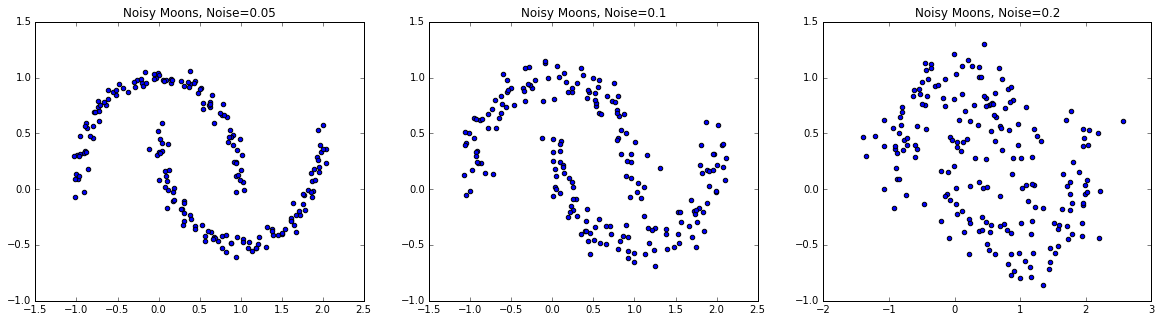

In [2]:
# generate dataset
noisy_moons = dict((noise, make_moons(n_samples, noise)) for noise in noise_level_list)

plt.figure(figsize=(20,5))
for i, (noise, training_set) in enumerate(sorted(noisy_moons.items())):
    plt.subplot(1,3,i+1)
    plt.title('Noisy Moons, Noise={}'.format(noise))
    plt.scatter(training_set[0][:,0], training_set[0][:,1])

plt.show()

In [3]:
# Question 2 :
from sklearn.neighbors import kneighbors_graph
n_neighbors_list = [1,5,10] # You can change these values

### Question 2 : Complete the code in the box below

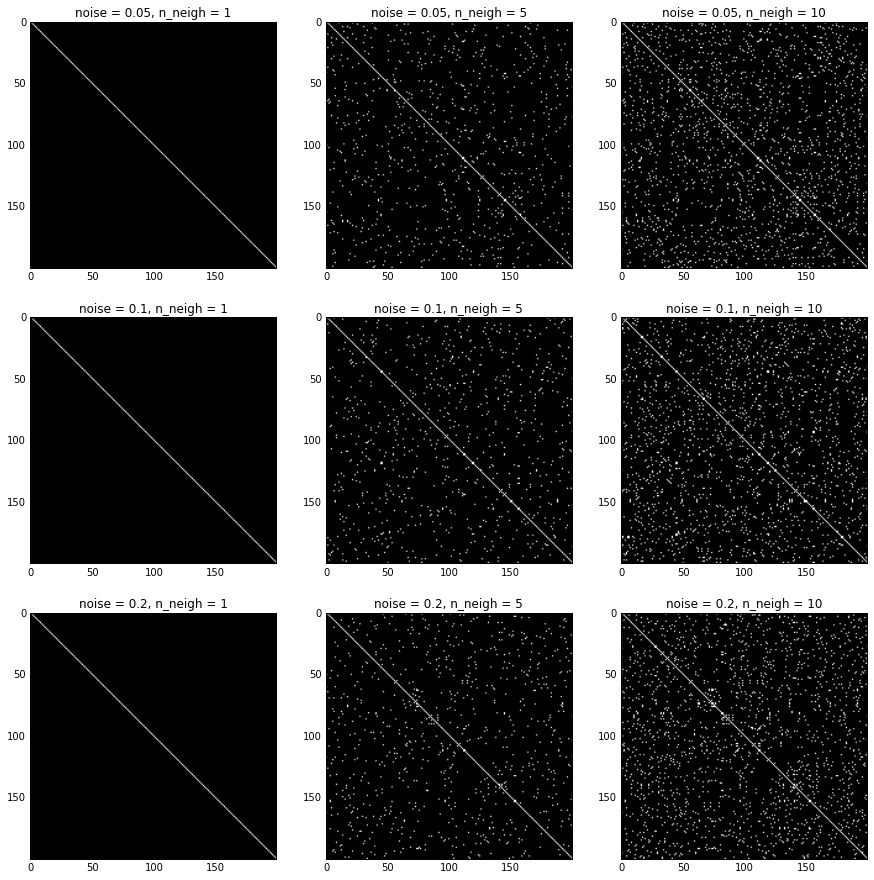

In [352]:
#import warnings
#warnings.filterwarnings("ignore")

A = dict( ((noise,k), kneighbors_graph(noisy_moons[noise][0],k)) 
          for noise in noise_level_list for k in n_neighbors_list ) 

plt.figure(figsize=(15,15))
for i, ((noise, k), graph) in enumerate(sorted(A.items())):
        plt.subplot(3,3, i+1)
        plt.title('noise = {0}, n_neigh = {1}'.format(noise, k))
        plt.imshow(graph.toarray(), cmap='gray', aspect='equal')
plt.show()

### Question 3 : Optimization problem 

Let $G = (V,E)$ the graph in question, and let $W$ be the similarity matrix of its nodes. We set its symmetric laplacian $L_{sym}$ as the matrix:

$$L_{sym} = D^{-1/2}WD^{-1/2},\text{ where } D \text{ is a diagonal matrix with } D_i = \sum_j w_{ij}$$

The Normalized Cut correponds to solving the following optimization problem:

$$\min_{f \in \mathbb{R}}{f^TL_{sym}f}, \text{ where } f \text{ is orthogonal to } D^{-1/2} 1 \text{ and } ||f||^2 = Vol(V)$$

### Question 4 : Complete the code in the box below



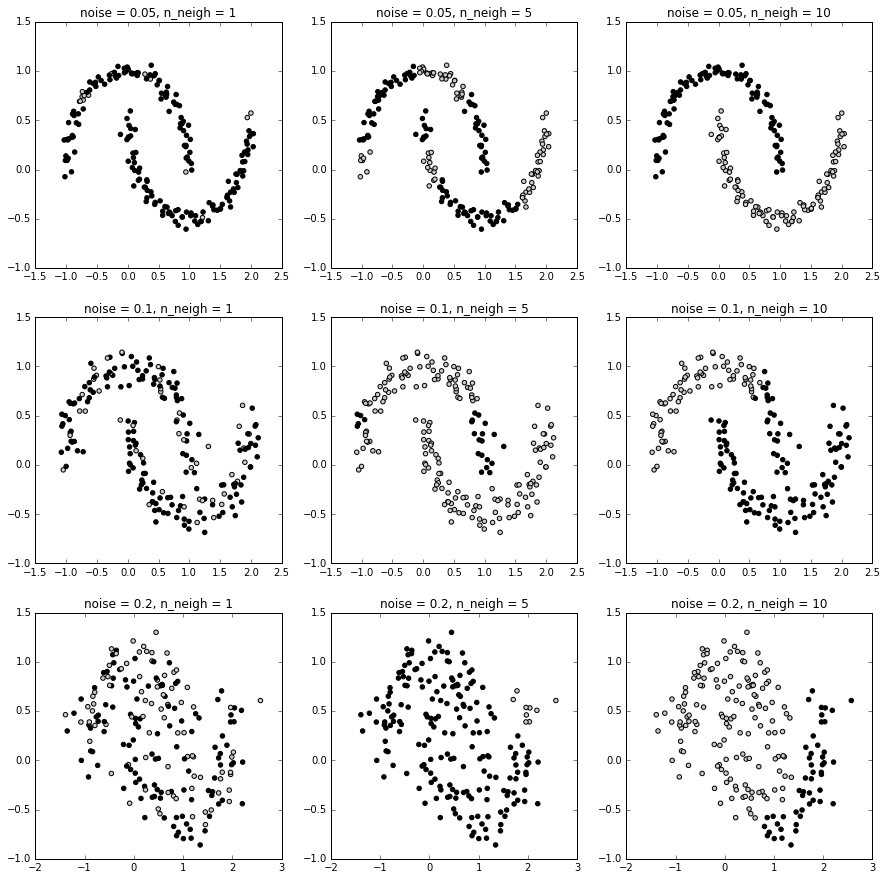

In [381]:
from sklearn.cluster import SpectralClustering

models = dict((key, SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=key[1])) for key in A )

plt.figure(figsize=(15,15))
for i, (key, model) in enumerate(sorted(models.items())):
    
    noise, n_neigh = key
    
    model.fit(A[key])
    y = model.fit_predict(A[key])
    X = noisy_moons[noise][0]
    
    plt.subplot(3,3,i+1)
    plt.title('noise = {0}, n_neigh = {1}'.format(noise, n_neigh))
    
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.spectral)

plt.show()

## Question 4: Conclusion

We observe that the clusters found by the algorithm depend of the value of k, but the changes made do not seem to be abrupt: variating k changes the clusters found slowly. We also note that for $k=1$ we do not get any good clustering results.

### Question 5 : Complete the code in the box below

In [6]:
from sklearn.utils import resample
from numpy.linalg import norm
from collections import defaultdict

def partition_matrix(y):
    """ Finds the partition matrix of a labeling vector y. """
    n = len(y)
    part = np.empty((n,n))
    for i, yi in enumerate(y):
        for j, yj in enumerate(y):
            part[i,j] = float(yi==yj)

    return part

def cossine_similarity(y, y_hat):
    """ Compute the cossine similarity between a labeling y and its prediction y_hat. """

    part = partition_matrix(y)

    part_hat = partition_matrix(y_hat)
    
    return np.dot(part.ravel(), part_hat.ravel())/(norm(part)*norm(part_hat))
    
def clustering_stability(clustering, dataset, B, C, **kwargs):
    """ This function measures the stability of a clustering algorithm.
    
    --Parameters--
    
    - clustering(data, C, **kwargs): function receiving a dataset (data) and a number of clusters(C), 
                                     and returns the array of predicted groups. **kwargs are all needed
                                     parameters to run the clustering algorithm
    - dataset: numpy array containing data
    - B: number of bootstrap samples
    - C: number of clusters
    
    """
    # parameters
    n = dataset.shape[0]
    stability = np.empty(B)
    
    # train on entire dataset
    groups = clustering(dataset, C, **kwargs)
    
    # samples from dataset
    for i in range(B):
        # sample 80% of dataset
        index = resample(np.arange(n), replace=False, n_samples=0.8*n)
        sampled_groups = groups[index]
        
        # train on sample
        result_on_sample = clustering(dataset[index], C, **kwargs)
        
        # compute stability
        stability[i] = cossine_similarity(sampled_groups, result_on_sample)
    
    return np.mean(stability)

### Question 6 : Complete the code in the box below

In [7]:
from functools import partial
from itertools import product

def spectral_cluster(dataset, C, k):
    """ Auxiliary clustering function for spectral clustering """
    # fit model
    model = SpectralClustering(n_clusters=C, affinity='nearest_neighbors', n_neighbors=k)
    model.fit(dataset)
    return model.labels_

C = 2
for noise, k in product(noise_level_list, range(1,11)):
    dataset = noisy_moons[noise][0]
    print 'Noise = {0}, k = {1}, stability = {2}'.format(noise, k, 
                                                         clustering_stability(spectral_cluster, dataset, 
                                                                               B=25, C=C, k=k))

Noise = 0.05, k = 1, stability = 0.564553915934
Noise = 0.05, k = 2, stability = 0.666069392335
Noise = 0.05, k = 3, stability = 0.82288449674
Noise = 0.05, k = 4, stability = 0.703723237447
Noise = 0.05, k = 5, stability = 0.806834762395
Noise = 0.05, k = 6, stability = 0.831527497435
Noise = 0.05, k = 7, stability = 0.946087487851
Noise = 0.05, k = 8, stability = 0.998034823901
Noise = 0.05, k = 9, stability = 0.987920855488
Noise = 0.05, k = 10, stability = 0.987122746241
Noise = 0.1, k = 1, stability = 0.67617327145
Noise = 0.1, k = 2, stability = 0.55852863615
Noise = 0.1, k = 3, stability = 0.835879313571
Noise = 0.1, k = 4, stability = 0.721237637936
Noise = 0.1, k = 5, stability = 0.788629499599
Noise = 0.1, k = 6, stability = 0.887314717728
Noise = 0.1, k = 7, stability = 0.915344220556
Noise = 0.1, k = 8, stability = 0.936009732804
Noise = 0.1, k = 9, stability = 0.954206467597
Noise = 0.1, k = 10, stability = 0.968452633806
Noise = 0.2, k = 1, stability = 0.651573512082
Nois

## Answer Q6

The stability criterion helps in choosing the value of $k$ since very unstable choises of $k$ are unlikely to have found very distinc clusters (it finds very different clusters when the dataset is removed of a few percentage of points).

### Question 7 : Complete the code in the box below

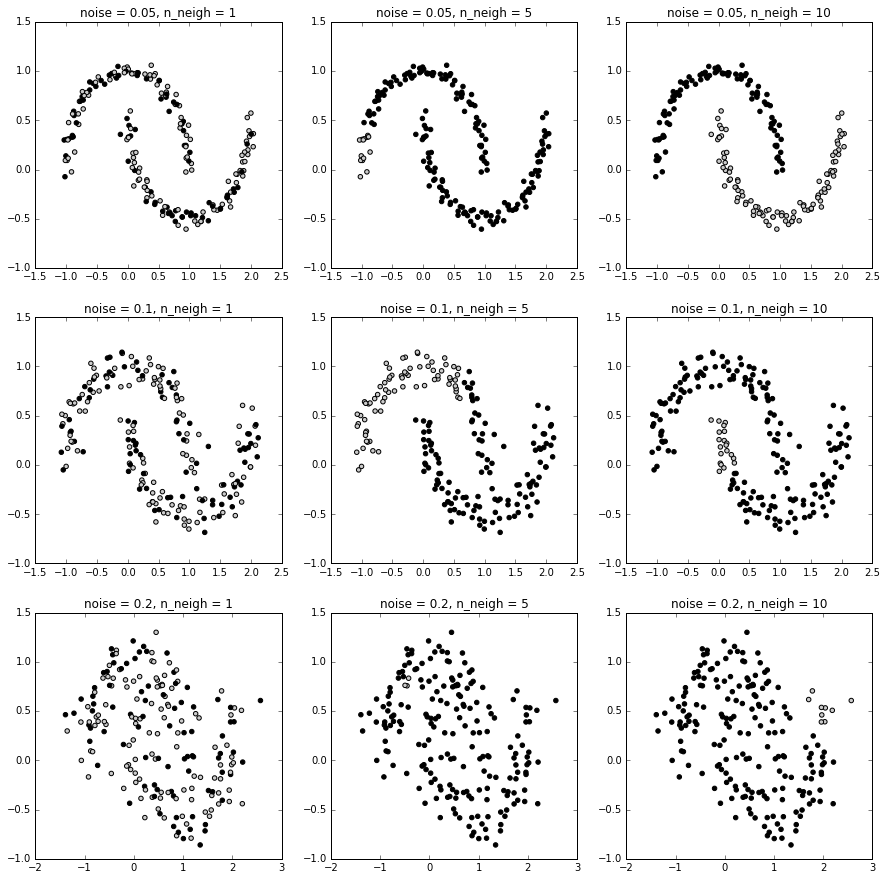

In [8]:
from sklearn.cluster import AgglomerativeClustering

C=2

plt.figure(figsize=(15,15))
for i, key in enumerate(sorted(A)):
    
    noise, n_neigh = key
    knn_graph = kneighbors_graph(X, n_neighbors=n_neigh)
    
    model = AgglomerativeClustering(linkage='complete',
                                    connectivity=knn_graph,
                                    n_clusters=C)
    model.fit(A[key].toarray())
    y = model.labels_
    X = noisy_moons[noise][0]
    
    plt.subplot(3,3,i+1)
    plt.title('noise = {0}, n_neigh = {1}'.format(noise, n_neigh))
    
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.spectral)

plt.show()

In [9]:
def hierarchical_cluster(dataset, C, k):
    """ Auxiliary clustering function for spectral clustering """
    # fit model
    knn_graph = kneighbors_graph(dataset, n_neighbors=k)
    
    model = AgglomerativeClustering(linkage='complete',
                                    connectivity=knn_graph,
                                    n_clusters=C)
    model.fit(dataset)
    return model.labels_

C = 2
for noise, k in product(noise_level_list, range(1,11)):
    dataset = noisy_moons[noise][0]
    print 'Noise = {0}, k = {1}, stability = {2}'.format(noise, k, 
                                                         clustering_stability(hierarchical_cluster, dataset, 
                                                                              B=25, C=C, k=k))

Noise = 0.05, k = 1, stability = 0.844865427396
Noise = 0.05, k = 2, stability = 0.847604444393
Noise = 0.05, k = 3, stability = 0.758836053586
Noise = 0.05, k = 4, stability = 0.765145113718
Noise = 0.05, k = 5, stability = 0.711977038824
Noise = 0.05, k = 6, stability = 1.0
Noise = 0.05, k = 7, stability = 0.939398030538
Noise = 0.05, k = 8, stability = 0.889317315377
Noise = 0.05, k = 9, stability = 0.788378583152
Noise = 0.05, k = 10, stability = 0.90690027839
Noise = 0.1, k = 1, stability = 0.733895812653
Noise = 0.1, k = 2, stability = 0.743737474589
Noise = 0.1, k = 3, stability = 0.711505225608
Noise = 0.1, k = 4, stability = 0.781705928702
Noise = 0.1, k = 5, stability = 0.824198813718
Noise = 0.1, k = 6, stability = 0.795703402046
Noise = 0.1, k = 7, stability = 0.724132377273
Noise = 0.1, k = 8, stability = 0.992252289935
Noise = 0.1, k = 9, stability = 0.990771355469
Noise = 0.1, k = 10, stability = 0.983816836407
Noise = 0.2, k = 1, stability = 0.763244226237
Noise = 0.2, 

### Experiment on MNIST

In [410]:
# Add your code here
from sklearn import datasets

digits = datasets.load_digits()

dataset = digits.images.reshape((len(digits.images), -1))

k=15
C_list = range(2,15)

for C in C_list:
    print 'C = {0}, k = {1}, stability = {2}'.format(C, k, 
                                                     clustering_stability(spectral_cluster, dataset, 
                                                                          B=10, C=C, k=k))

C = 2, k = 15, stability = 1.0
C = 3, k = 15, stability = 0.990330900586
C = 4, k = 15, stability = 0.861128936092
C = 5, k = 15, stability = 0.823985777676
C = 6, k = 15, stability = 0.984243637496
C = 7, k = 15, stability = 0.850794707871
C = 8, k = 15, stability = 0.817228699296
C = 9, k = 15, stability = 0.949362847499
C = 10, k = 15, stability = 0.95047108409
C = 11, k = 15, stability = 0.972717672332
C = 12, k = 15, stability = 0.976575238503
C = 13, k = 15, stability = 0.970966429936
C = 14, k = 15, stability = 0.933439205035


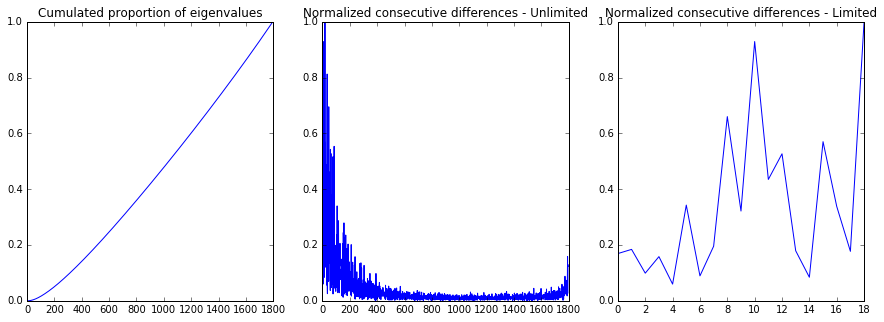

In [409]:
# affinity matrix
W = kneighbors_graph(dataset, n_neighbors=15, include_self=True).toarray()
W = 0.5*(W + W.T)

# symmetric laplacian
d = np.sum(W, axis=1)
D = np.diag(d)
D1 = np.diag(d**(-0.5))
Lsym =  np.dot(D1, np.dot(D-W, D1))

# cumulated eigenvalue plot
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
eigs = np.sort(np.linalg.eigvals(Lsym))
plt.title('Cumulated proportion of eigenvalues')
plt.plot(np.cumsum(eigs)/sum(eigs))

plt.subplot(1,3,2)
diffs = eigs[1:]-eigs[:-1]
diffs /= max(diffs)
ind = np.argmax(diffs)
plt.title('Normalized consecutive differences - Unlimited')
plt.plot(diffs/max(diffs))

plt.subplot(1,3,3)
plt.title('Normalized consecutive differences - Limited')
plt.plot(diffs[:ind+1]/max(diffs))

plt.show()

## Commentaries

We note that the eigenvalues' plot is reasonably informative, since it allows us to vizualize where the gaps appear and restrict our choices to only a few values (in our case, C = 10 and C = 18 are reasonable gaps to be chosen).

In the other hand, the stability property also tells us that...

## Semi-Supervised Learning

Choice of the dataset used : **Precise** which dataset you chose and why it is relevant for the semi-supervised learning Task

Advised datasets :

*Breast Cancer Wisconsin (Diagnostic) Database*

*MNIST binary even vs odd (multiple clusters inside each class)*

Feel free to use other datasets if they are relevant

In [11]:
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.cross_validation import train_test_split


### For all the next questions, use Cancer and Mnist classes to handle your data if you choose to use these one,
### You can also add more datasets but we advise you to handle them with this class for better readability
class semi_sup_dat:
    def __init__(self,data,p_unlabelled,name):
        # DON T CHANGE THE RANDOM STATES
        self.name = name
        if self.name == 'Mnist':
            # do an even vs odd binary classification :
            even = [0,2,4,6,8]
            Y = [int(y in even) for y in data.target]
        else:
            Y = data.target
        X_lab, X_unlab, y_lab, y_unlab = train_test_split(data.data, Y, test_size=p_unlabelled, random_state=32)
        self.X_lab = X_lab
        self.X_unlab = X_unlab
        self.y_lab = y_lab
        self.y_unlab = y_unlab


# The following lines can be called later in the code to build a dataset with varying unlabelled proportion
p_unlabelled = 0.8 # You can change this value
Cancer = semi_sup_dat(load_breast_cancer(), p_unlabelled,'Cancer')
digits = load_digits()

Mnist = semi_sup_dat(load_digits(), p_unlabelled,'Mnist')

### Question 9 : Complete the code in the box below

In [412]:
#  Question 9  : Complete the function self_training
from sklearn.neighbors import KNeighborsClassifier
from collections import namedtuple
    
named_datasets = namedtuple('dataset', ['data', 'target'])

toyset = semi_sup_dat(named_datasets(*noisy_moons[0.05]), p_unlabelled, 'Toy')

In [413]:
def self_training(classifier, data):
    k = 0
    
    # variables
    Sx, Sy = data.X_lab, data.y_lab
    Ux = data.X_unlab
    
    while len(Ux) > 0:
        # train classifier
        classifier.fit(Sx, Sy)
        
        # label unclassified data
        pred = classifier.predict_proba(Ux)
        
        # find most confident predictions (another option is to choose the most confident prediction at each step)
        best = np.max(pred, axis=1) > 0.8
        #best = (pred == np.max(pred))
        
        # increase label dataset and decrease unlabeled dataset
        try:
            Sx = np.vstack([Sx, Ux[best]])
            Sy = np.hstack([Sy, classifier.predict(Ux[best])])
            Ux = Ux[~best]
        except:
            break

In [416]:
# testing self-learning algorithm over toy dataset

classifier = KNeighborsClassifier(n_neighbors=10)        
self_training(classifier, toyset)
print 'We have a performace score of unlabeled data of:', classifier.score(toyset.X_unlab, toyset.y_unlab)

 We have a performace score of unlabeled data of: 1.0


In [414]:
# testing self-learning algorithm over real dataset

classifier = KNeighborsClassifier(n_neighbors=10)        
self_training(classifier, Mnist)
print 'We have a performace score of unlabeled data of:', classifier.score(Mnist.X_unlab, Mnist.y_unlab)

We have a performace score of unlabeled data of: 0.986091794159


### Question 10 : Complete the code in the box below

###### Closed form expression :

$$
\alpha^* = \left(JK + \lambda l I + \frac{\lambda_u l}{(l+u)^2} LK \right)^{-1} Y
$$

where $J$ is a block-diagonal matrix (first a $I_{l}$ block followed by a $0_{u}$ block), $Y = (y_1, \dots, y_l, 0, \ldots, 0)$, $L$ is the Laplacian matrix and $K$ is the kernel matrix $K_{ij} = K(x_i, x_j)$.

### Question 11 : Complete the code in the box below

In [411]:
from sklearn.metrics.pairwise import rbf_kernel # Or reimplement it yourself if your prefer
from scipy.linalg import block_diag

def lapRLS(data, k, lamb, lamb_u):
    # parameters
    l,u = len(data.X_lab), len(data.X_unlab) 
    X = np.vstack([data.X_lab, data.X_unlab])
    Y = np.hstack([data.y_lab, np.zeros(u)])
    
    J = block_diag(np.eye(l), np.zeros((u,u)))
    K = rbf_kernel(X,X)
    W = kneighbors_graph(X, n_neighbors=k).toarray()
    W = 0.5*(W + W.T)
    L = np.diag(np.sum(W, axis=1)) - W
    
    M = np.dot(J,K) + (lamb*l)*np.eye(l+u) + (lamb_u*l/float((l+u)**2)) * np.dot(L,K)

    alpha = np.dot(np.linalg.inv(M), Y)

    return np.dot(K, alpha)

In [162]:
from itertools import product

lamb_list = [0.001, 0.01, 0.1, 1.0, 10, 100]
lamb_u_list = [0.001, 0.01, 0.1, 1.0, 10, 100]

var = []

# checking the influence of lamb_u
for lb in lamb_list:
    fs = []
    
    for lbu in lamb_u_list:
        fs.append(lapRLS(testdata, 10, lb, lbu))
    
    var = (np.var(fs))
    print 'For lambda = {0}, the variance of f is: {1}'.format(lb, var)

For lambda = 0.001, the variance of f is: 0.225013922838
For lambda = 0.01, the variance of f is: 0.158542755911
For lambda = 0.1, the variance of f is: 0.0627171651527
For lambda = 1.0, the variance of f is: 0.00518818478547
For lambda = 10, the variance of f is: 8.59238177963e-05
For lambda = 100, the variance of f is: 9.14931242717e-07


## Answer Q11

We note that for large values of $\lambda$, the variable $\lambda_u$ does not influence much in the value of $f$ (small variance above). In contrast, the smaller the value of $\lambda$, the more influential is $\lambda_u$ in the solution $f$ (higher variance).

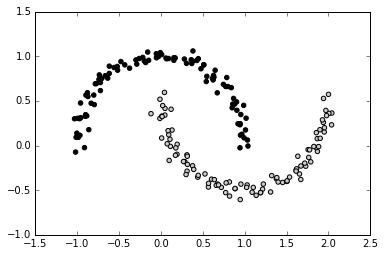

In [431]:
from sklearn.cluster import KMeans

# test lapRLS over toy dataset
X = np.vstack([toyset.X_lab, toyset.X_unlab])

f = lapRLS(toyset, k=10, lamb=0.001, lamb_u=1.0)
clust = KMeans(2)
clust.fit(f.reshape(-1,1))
lab = clust.labels_

plt.scatter(X[:,0], X[:,1], c=lab, cmap=plt.cm.spectral)
plt.show()

### Question 12 : Add your answer here

Computing the closed form solution involves inverting a matrix, which may be very costly in practice (especially for large n).  

### Question 13 : Complete the code in the box below

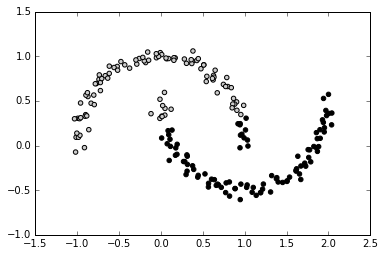

In [429]:
def SGDLapRLS(data, k, lamb, lamb_u, step, max_iter):
    
    l,u = len(data.X_lab), len(data.X_unlab) 
    X = np.vstack([data.X_lab, data.X_unlab])
    Y = np.hstack([data.y_lab, np.zeros(u)])

    J = block_diag(np.eye(l), np.zeros((u,u)))
    K = rbf_kernel(X,X)
    W = kneighbors_graph(X, n_neighbors=k).toarray()
    W = 0.5*(W + W.T)
    L = np.diag(np.sum(W, axis=1)) - W

    JK = np.dot(J,K)
    KLK = np.dot(K, np.dot(L,K))
    KJK = np.dot(K,JK)
    c = lamb_u/float((l+u)**2)
    
    # algorithm
    iis = np.random.randint(0, l+u, max_iter)
    alpha = np.zeros(l+u)

    for t, i in enumerate(iis):
        grad = 2*np.dot(KJK,alpha)/l -2*np.dot(JK.T,Y)/l+ 2*lamb*np.dot(K,alpha) + 2*c*np.dot(KLK,alpha)
        alpha -= (step / np.sqrt(t+1)) * grad
        
    return np.dot(K,alpha)

X = np.vstack([toyset.X_lab, toyset.X_unlab])

f = SGDLapRLS(toyset, 10, 0.001, 1, 0.1, 100)
clust = KMeans(2)
clust.fit(f.reshape(-1,1))
lab = clust.labels_

plt.scatter(X[:,0], X[:,1], c=lab, cmap=plt.cm.spectral)
plt.show()

### Question 14 : Complete the code in the box below

##### Add your answer to the question here :

After the work in the paper [2], the dual problem can be written as:

$$
\min_{\beta \in \mathbb{R}^l} \frac{1}{2} \beta^T Q \beta - \sum_{i=1}^l \beta_i
$$

subject to:

$$
\sum_{i=1}^l \beta_i y_i = 0, \,\,\,\,\, 0 \leq \beta_i \leq \frac{1}{l}
$$

where $Q = YJK \left(2\lambda I + 2 \frac{\lambda_u}{(l+u)^2} LK \right)^{-1} J^T Y$ with $J = [I_l | 0_u]$ and $Y = diag(y_1, \ldots, y_l)$.

Once $\beta$ is computed by means of a quatratic problem minimizer, we can compute $\alpha$ as:

$$
\alpha = \left(2\lambda I + 2 \frac{\lambda_u}{(l+u)^2} LK \right)^{-1} J^T Y \beta
$$

In [373]:
import cvxopt

def qp(Q, p, A, b, C, verbose=True):
    # Gram matrix
    n = Q.shape[0]
    Q = cvxopt.matrix(Q)
    A = cvxopt.matrix(A, (1, n))
    p = cvxopt.matrix(p)
    b = cvxopt.matrix(b)
    
    G = cvxopt.matrix(np.vstack([np.diag(np.ones(n) * -1), np.diag(np.ones(n))]))
    h = cvxopt.matrix(np.hstack([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(Q, p, G, h, A, b)
 
    # Lagrange multipliers
    beta = np.ravel(solution['x'])
    return beta

def svm_solver(data, k, lamb, lamb_u):
    l,u = len(data.X_lab), len(data.X_unlab) 
    X = np.vstack([data.X_lab, data.X_unlab])
    
    K = rbf_kernel(X,X)
    Y = np.diag(data.y_lab)
    
    J = np.hstack([np.eye(l), np.zeros((l,u))])
    W = kneighbors_graph(X, n_neighbors=k).toarray()
    W = 0.5*(W + W.T)
    L = np.diag(np.sum(W, axis=1)) - W
    
    M = 2*lamb*np.eye(l+u) + 2*(lamb_u/float((l+u)**2)) * np.dot(L,K)
    M = np.dot(np.linalg.inv(M), np.dot(J.T, Y))
    Q = np.dot(Y, np.dot(J,K))
    Q = np.dot(Q, M)

    p = -np.ones(l)
    A = 1.0*data.y_lab.copy()
    beta = qp(Q, p, A, b=0.0, C=1.0/l, verbose=False)

    beta[np.where(beta < 1.0e-5)] = 0.0
    beta[np.where(1./l - beta < 1.e-5)] = 1./l

    inds = np.where(np.logical_and(beta>0, beta<1./l))
    
    
    #print beta[idx_support]
    #print M[:,idx_support]
    alpha = np.dot(M, beta)
    b = data.y_lab[inds] - np.dot(K,alpha)[inds]
    
    #print alpha
    return np.dot(K,alpha) + b[0]

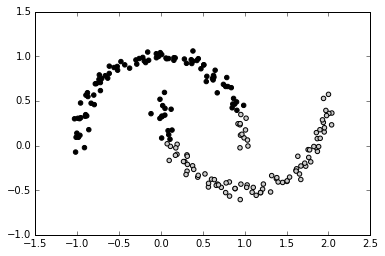

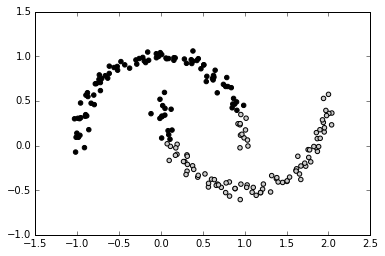

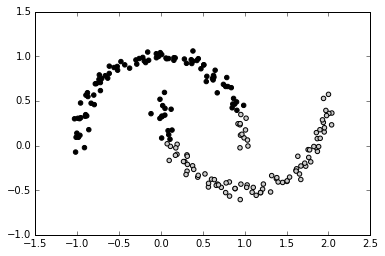

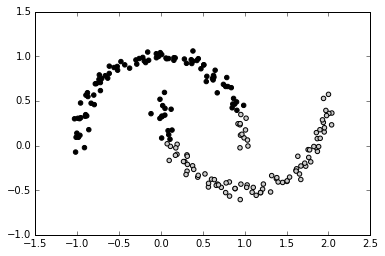

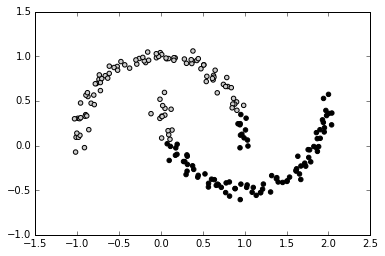

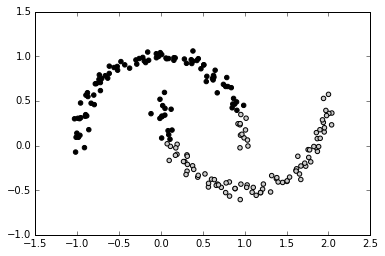

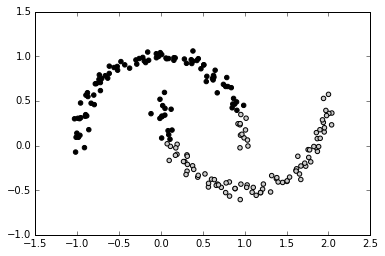

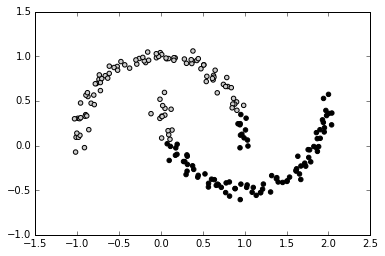

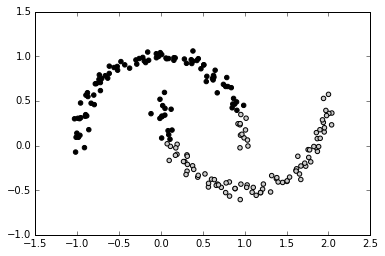

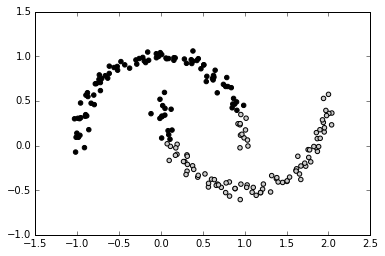

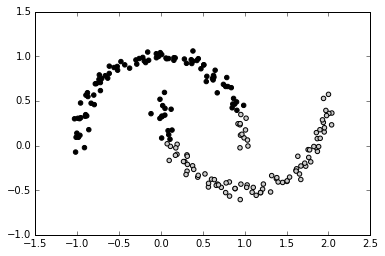

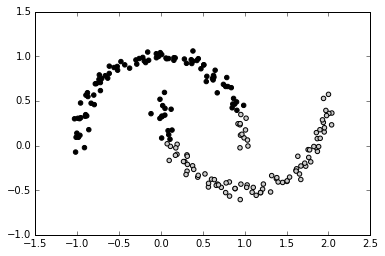

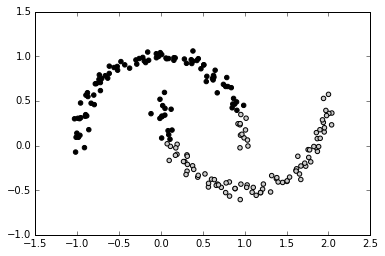

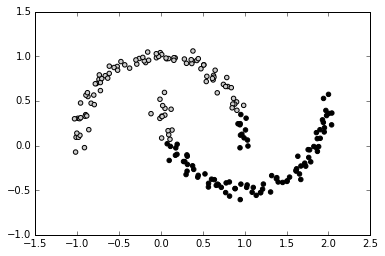

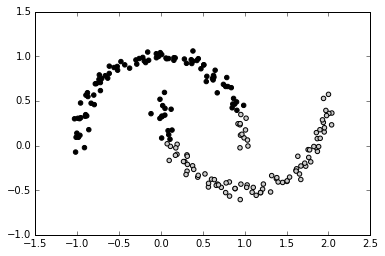

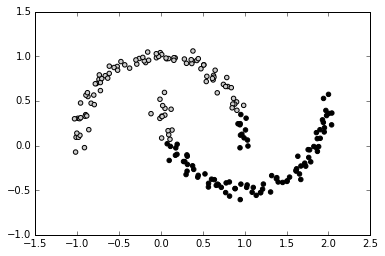

In [432]:
from sklearn.cluster import KMeans

td = semi_sup_dat(test(*noisy_moons[0.05]), 0.8, 'Moon')
td.y_lab[td.y_lab == 0] = -1

lamb_u_list = [0.1, 1.0, 10, 100]
#lamb_u_list = [0.01]

X = np.vstack([td.X_lab, td.X_unlab])

for lb, lu in product(lamb_u_list, lamb_u_list):
    f = svm_solver(td, 10, lb, 100)

    clust = KMeans(2)
    clust.fit(f.reshape(-1,1))
    lab = clust.labels_

    plt.scatter(X[:,0], X[:,1], c=lab, cmap=plt.cm.spectral)
    plt.show()

### Question 15 : Complete the code in the box below

In [420]:
base_learners = []
classfiers = []
percentages = [0.2, 0.4, 0.6, 0.8]
k = 10

for p_unlabelled in percentages:
    print 'p_unlabelled:', p_unlabelled
    
    data = semi_sup_dat(load_breast_cancer(), p_unlabelled, 'Cancer')
    
    classifier = KNeighborsClassifier(n_neighbors=10)        
    self_training(classifier, data)
    print 'p_unlab = {0}, Self-training score: {1}'.format(p_unlabelled, classifier.score(data.X_unlab, data.y_unlab))
    
    
    X = np.vstack([data.X_lab, data.X_unlab])

    f = lapRLS(data, k=10, lamb=0.001, lamb_u=1.0)
    clust = KMeans(2)
    clust.fit(f.reshape(-1,1))
    lab = clust.labels_
    
    print 

p_unlabelled: 0.2
p_unlab = 0.2, Self-training score: 0.868421052632
p_unlabelled: 0.4
p_unlab = 0.4, Self-training score: 0.912280701754
p_unlabelled: 0.6
p_unlab = 0.6, Self-training score: 0.921052631579
p_unlabelled: 0.8
p_unlab = 0.8, Self-training score: 0.914473684211


### Question 16 : Complete the code in the box below

###### Describe your protocol here : 
-

-

-